### ETAS: Ridgecrest, 4ish July, 2019

Time
2019-07-04 17:33:49 (UTC)
Location
35.705°N 117.506°W
Depth
10.7 km

In [6]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
os.environ['PROJ_LIB'] = '{}/anaconda3/share/proj'.format(os.getenv('HOME'))
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep

#import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

In [11]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#to_dt = dtm.datetime(2019,7,5,0,0,0, tzinfo=pytz.timezone('UTC'))
#
Lr_factor = 10.
# define these from the t_now in the actual etas object, in the event that we load it from pickle,
#  rather than calc it here.
#f_path = '/home/myoder/Dropbox/Research/etas/italy_2016_10/etas_{}'.format(to_dt)
#f_root = 'etas_2016'
#

t0 = dtm.datetime.now(pytz.timezone('UTC'))
t_ms = t0
#
# sacramento:
lat0 = 35.705
lon0 = -117.506
#
#ll_sacramento = (lon0, lat0)

#m0 = 7.8

d_lat=2.
d_lon=2.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 't_future':None ,
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': 2.5, 'q_cat': 1.5,
               'p_etas':1.1, 'q_etas':1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
#eq_prams.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})

In [12]:
# let's add a preliminary map...
class Preliminary_Map(object):
    def __init__(self, lats, lons):
        pass
#
# comcat may not be working (overloaded, probably after the earthquake):
# try anss:
mycat = None
#
#mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=pytz.timezone('UTC')), 
                                dtm.datetime.now(pytz.timezone('UTC'))],
                            Nmax=None, fout=None, rec_array=True)
#                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)

mycat = gep.make_ETAS_catalog_mpp(incat=mycat, n_cpu=None)

etas_prams:  {'incat': None, 'lats': [32.0, 38.0], 'lons': [-117.0, -114.0], 'mc': 2.5, 'date_range': ['1990-1-1', None], 'D_fract': 1.5, 'd_lambda': 1.76, 'd_tau': 2.28, 'fit_factor': 1.5, 'p': 1.1, 'q': 1.5, 'dmstar': 1.0, 'b1': 1.0, 'b2': 1.5, 'do_recarray': False}
results fetched.


In [13]:
#eq_prams['t_now'] = dtm.datetime(2019,7,6,18,0,0, tzinfo=pytz.timezone('UTC'))
eq_prams['t_now'] = dtm.datetime.now(pytz.timezone('UTC'))
# eq_prams['lats'] = [lat0 - 1., lat0 + 1.]
# eq_prams['lons'] = [lon0 - 1., lon0 + 1.]
#
# eq_prams['lats'] = [lat0 - 2., lat0 + 2.]
# eq_prams['lons'] = [lon0 - 2., lon0 + 2.]
#
n_cpu = 2*mpp.cpu_count()
#n_cpu=5
etas = gep.ETAS_mpp(n_cpu=n_cpu, catalog=mycat, **eq_prams)
#
# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-31 16:31:48.531566+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 5262], None)
make_etas():
etas_mpp worker xyz_range:  [0, 100]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-31 16:31:48.531566+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 5262], [0, 100])
etas_mpp worker xyz_range:  [100, 200]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-31 16:31:48.531566+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 5262], [100, 200])
etas_mpp worker xyz_range:  [200, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - c

finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 5262])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 5262])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 5262])
ETAS complete.


In [14]:
event_name = 'Ridgecrest_July_2019'
#f_path = '/home/myoder/Dropbox/Research/etas/{}/etas_{}'.format(event_name, etas.t_now)
#f_path = '{}/data_export/Research/etas/{}/etas_{}'.format(os.getenv('HOME'), event_name, etas.t_now)
f_path = '{}/Dropbox/Research/etas/{}/etas_{}'.format(os.getenv('HOME'), event_name, etas.t_now)
f_root = 'etas_{}_2019_07'.format(event_name)

In [ ]:
print( etas.t_now, etas.t_forecast, etas.catalog[-1])

2019-07-29 16:31:48.531566+00:00 737269.6887561524 ('2019-07-29T15:40:20.630000', 35.9968333, -117.4125, 2.82, 0.79, 737269.65301655, 0.44668359, 0.03315047, 52.57571022, 0.13489629, 0.00168244, 90.65798957, 1., 1.1, 1.5, 0.13655453, [1., 1.], [[1., 0.], [0., 1.]], 2.)


/Users/myoder96/Codes/globalETAS/globalETAS.py:339: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  cm = Basemap(llcrnrlon=lons_map[0], llcrnrlat=lats_map[0], urcrnrlon=lons_map[1], urcrnrlat=lats_map[1], resolution=map_resolution, projection=map_projection, lon_0=cntr[0], lat_0=cntr[1], ax=ax)
/Users/myoder96/Codes/globalETAS/globalETAS.py:343: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  cm.drawcountries(color='black', zorder=1)
/Users/myoder96/Codes/globalETAS/globalETAS.py:344: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if do_states: cm.drawstates(color='black', zorder=1)
/Users/myoder96/Codes/globalETAS/globalETAS.py:345: MatplotlibDeprecationWarning: 
The dedent function was deprecated in 

ms:  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.09925776, 0.06681855], [[ 0.85764175,  0.51424764], [-0.51424764,  0.85764175]], 2642.) -117.5993333 35.7695
tt:  737254.6887561524 2005-01-04T08:21:35.380000 <class 'numpy.datetime64'>


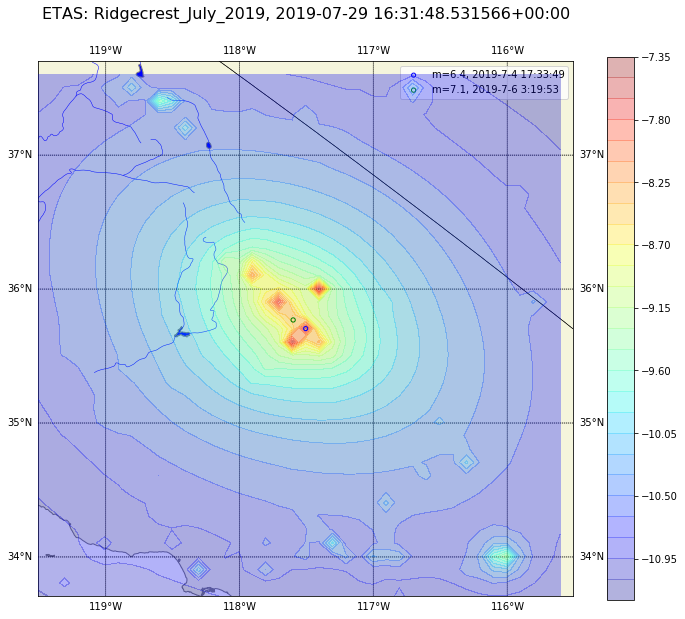

In [ ]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
# lats_map= , lons_map=
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

#x,y = etas.cm(*ll_sacramento)
#etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
#                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
plt.gca().legend()
#print(etas.catalog[-10:])

In [ ]:
fg2=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
# for j,m6 in enumerate(m6s):
#     clr = colors_[j%len(colors_)]
#     #
#     dt = m6['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
#                           c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

# ix = (numpy.array([pytz.utc.localize(x.astype(dtm.datetime)) for x in etas.catalog['event_date']])<=etas.t_now and
#       numpy.array([pytz.utc.localize(x.astype(dtm.datetime)) 
#                    for x in etas.catalog['event_date']])>=dtm.datetime(2019,7,4, tzinfo=pytz.timezone('UTC')))
ix = numpy.array([x<=etas.t_now and x>dtm.datetime(2019,7,4, tzinfo=pytz.timezone('UTC'))
      for x in [pytz.utc.localize(x.astype(dtm.datetime)) for x in etas.catalog['event_date']]])
#
etas.cm.plot(etas.catalog['lon'][ix], etas.catalog['lat'][ix], marker='.', ls='')
#x,y = etas.cm(*ll_sacramento)
#etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
#                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
ax.legend(loc=0)
#print(etas.catalog[-10:])

In [ ]:
print(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5])
len(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5
     and rw['event_date'].astype(dtm.datetime)>dtm.datetime(2016,10,20)])



In [ ]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))))
etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg2.savefig(os.path.join(f_path, '{}_{}_with_equakes.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))


#
# so this worked, once upon a time, but breaks maybe when the script does not run cleanly all the way through?
with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
   pickle.dump(etas, fpkl)


In [ ]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

In [ ]:
# How 'bout some intervals and magnitudes:
#
# (we should probably build this plot int the class, or really, we should make a separate plotter class, that
#  takes and ETAS object as an input.)
#
fg = plt.figure(figsize=(14,7))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
ax2.set_xlabel('time $t$')
#
n_int = 100
X = etas.catalog['event_date_float']
ix_m = etas.catalog['mag']>6.1
ix_m5 = etas.catalog['mag']>5.0
intervals = numpy.array(X[n_int:] - X[0:-n_int] )/float(n_int)
#
ax1.plot(X[n_int:], intervals, ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(X[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax1.vlines(X[ix_m5], min(intervals), .5*max(intervals), color='r', ls='--', lw=2.5)
ax2.vlines(etas.catalog['event_date_float'], etas.catalog['mag'], min(etas.catalog['mag'])-2., color='b', lw=2.)
#ax1.set_xlim(726000)
#
#
#####
fg2 = plt.figure(figsize=(14,7))
ax1 = fg2.add_subplot('211')
ax2 = fg2.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
#
ax2.set_xlabel('Event Count $n$ (Natural time)')
#
ax1.plot(numpy.arange(1, len(intervals)+1), intervals, ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(numpy.arange(len(etas.catalog))[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax2.vlines(numpy.arange(len(etas.catalog)), etas.catalog['mag'], min(etas.catalog['mag'])-2., color='b', lw=2.)
#

In [ ]:
# now, let's look at that last one up close:
#
#####
fg2 = plt.figure(figsize=(14,7))
ax1 = fg2.add_subplot('211')
ax2 = fg2.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
#
ax2.set_xlabel('Event Count $n$ (Natural time)')
#
#
k0 = 3400
ax1.plot(numpy.arange(1+k0, len(intervals)+1), intervals[k0:], ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(numpy.arange(len(etas.catalog))[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax2.vlines(numpy.arange(k0, len(etas.catalog)), etas.catalog['mag'][k0:], min(etas.catalog['mag'])-2., color='b', lw=2.)
#
ax1.set_ylim(-.01, .05)

In [ ]:
print(etas.catalog.dtype.names)

In [ ]:
# plot a cross-section of ETAS. let's get smart about this and do a PCA on the xyz field...
#
#plt.figure()
##my_xy = [[x,y,z] for x,y in zip(etas.catalog['lon'], etas['lat']) if x>=42.25 and x<=42.75]
#my_xyz = [[x,y,z] for x,y,z in etas.ETAS_array if y>=42.25 and y<=42.75]
#plt.figure(figsize=(8,6))
#plt.plot([x for x,y,z in my_xyz ], [z for x,y,z in my_xyz], '.')

In [ ]:
mainshocks = sorted(etas.catalog[etas.catalog['event_date']>dtm.datetime(2019,6,20)],
                    key=lambda rw:rw['mag'])[-2:]
#
print('** mainshocks: ', mainshocks)

In [ ]:
ix = etas.catalog['event_date']>dtm.datetime(2019,6,20)

ms2 = (etas.catalog[ix])[numpy.argsort( (etas.catalog[ix])['mag'])[-2:]]
print('** ms2: ', ms2)